In [16]:
import pandas as pd

df = pd.read_parquet('train_data.parquet',engine='pyarrow')



In [17]:
df=df.head(30000)

Shape after dropping all-NaN columns: (30000, 352)
Imputed array shape: (30000, 352)


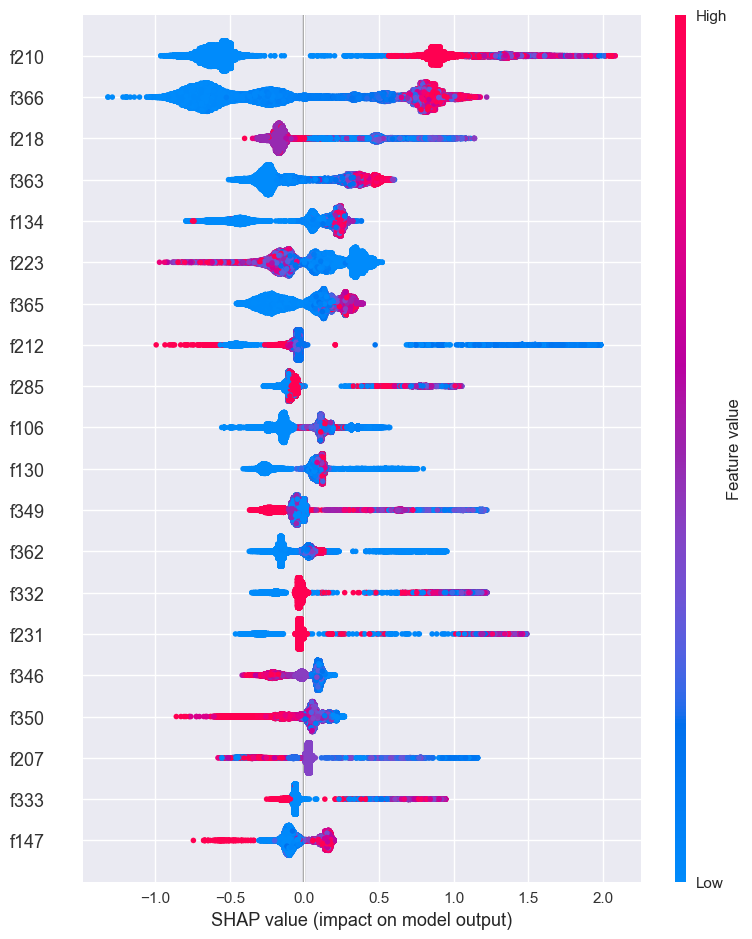

Important Features Kept: ['f1', 'f2', 'f6', 'f7', 'f8', 'f9', 'f10', 'f22', 'f26', 'f27', 'f30', 'f31', 'f32', 'f35', 'f38', 'f39', 'f41', 'f43', 'f45', 'f46', 'f47', 'f51', 'f59', 'f60', 'f67', 'f68', 'f73', 'f74', 'f76', 'f77', 'f90', 'f91', 'f95', 'f96', 'f106', 'f109', 'f111', 'f113', 'f114', 'f115', 'f121', 'f123', 'f124', 'f125', 'f126', 'f127', 'f130', 'f131', 'f132', 'f133', 'f134', 'f137', 'f138', 'f140', 'f141', 'f142', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f166', 'f169', 'f170', 'f171', 'f173', 'f177', 'f181', 'f182', 'f183', 'f184', 'f192', 'f196', 'f204', 'f206', 'f207', 'f208', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f222', 'f223', 'f224', 'f225', 'f231', 'f252', 'f261', 'f285', 'f288', 'f310', 'f311', 'f312', 'f314', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f330', 'f332', 'f333', 'f337', 'f338', 'f339', 'f340', 'f342', 'f343', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

# -----------------------------
# Step 1: Load and Clean Data
# -----------------------------
# final_df = pd.read_csv("your_dataset.csv")  # If reading from file

df = final_df.copy()


id_cols = ['id1', 'id2', 'id3', 'id4', 'id5']
df = df.drop(columns=id_cols, errors='ignore')

df = df.replace(-9999.0, np.nan)

def convert_to_numeric(val):
    if isinstance(val, str):
        val = val.replace(",", "")  # remove commas
    try:
        return float(val)
    except:
        return np.nan

for col in df.columns:
    if col != 'y':  # skip target column
        df[col] = df[col].apply(convert_to_numeric)



df['y'] = df['y'].astype(int)

X = df.drop(columns=['y'])
y = df['y']

X = X.dropna(axis=1, how='all')
print(f"Shape after dropping all-NaN columns: {X.shape}")

# Step 6: Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed_array = imputer.fit_transform(X)
print(f"Imputed array shape: {X_imputed_array.shape}")

# ✅ Use correct number of column names
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns)


# imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# -----------------------------
# Step 2: Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Step 3: Use SMOTE on training set
# -----------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# -----------------------------
# Step 4: Train Initial CatBoost
# -----------------------------
initial_model = CatBoostClassifier(
    iterations=300, learning_rate=0.05, depth=6, verbose=0, random_state=42
)
initial_model.fit(X_train_smote, y_train_smote)

# -----------------------------
# Step 5: SHAP for Feature Importance
# -----------------------------
explainer = shap.Explainer(initial_model)
shap_values = explainer(X_train_smote)

# Visualize SHAP summary
shap.summary_plot(shap_values, X_train_smote)

# -----------------------------
# Step 6: Drop Low-Importance Features
# -----------------------------
# Use mean |SHAP| value threshold to filter features
shap_mean = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({"feature": X_train_smote.columns, "mean_shap": shap_mean})
important_features = shap_df[shap_df["mean_shap"] > 0.01]["feature"].tolist()

print("Important Features Kept:", important_features)

X_train_final = X_train_smote[important_features]
X_test_final = X_test[important_features]

# -----------------------------
# Step 7: Train Final Model
# -----------------------------
# final_model = CatBoostClassifier(**best_params)
# final_model.fit(X_train_final, y_train_smote)



# # -----------------------------
# # Step 8: Evaluate Model
# # -----------------------------
# y_probs = final_model.predict_proba(X_test_final)[:, 1]
# map_score = average_precision_score(y_test, y_probs)

print(f"\n✅ Final MAP Score after SHAP + SMOTE + Cleaning: {map_score:.4f}")


In [30]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_state': 42,
        #'task_type': 'GPU'  # Remove this line if you are not using GPU
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_final, y_train)

    y_probs = model.predict_proba(X_test_final)[:, 1]
    return average_precision_score(y_test, y_probs)

# Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Can increase to 100 or more for better results

print("Best parameters:", study.best_params)
print("Best MAP score:", study.best_value)


[I 2025-07-13 14:12:06,609] A new study created in memory with name: no-name-a4aa3123-5dec-495c-a167-4ed9105cf312
[W 2025-07-13 14:12:06,612] Trial 0 failed with parameters: {'iterations': 914, 'learning_rate': 0.20015582417285524, 'depth': 6, 'l2_leaf_reg': 9.832342302848746, 'bagging_temperature': 0.4224696704984603, 'border_count': 105, 'random_strength': 3.311429940128091} because of the following error: CatBoostError('Length of label=24000 and length of data=45648 is different.').
Traceback (most recent call last):
  File "c:\Users\Rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Rohit\AppData\Local\Temp\ipykernel_7680\1025179420.py", line 21, in objective
    model.fit(X_train_final, y_train)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y

CatBoostError: Length of label=24000 and length of data=45648 is different.

In [ ]:
best_params = study.best_params
best_params.update({'random_state': 42, 'verbose': 0})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)
y_probs = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import average_precision_score
final_map = average_precision_score(y_test, y_probs)
print("Final MAP score after tuning:", final_map)

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

id_cols = ['id1', 'id2', 'id3', 'id4', 'id5']
df = df.drop(columns=id_cols, errors='ignore')

df = df.replace(-9999.0, np.nan)

def convert_to_numeric(val):
    if isinstance(val, str):
        val = val.replace(",", "")  # remove commas
    try:
        return float(val)
    except:
        return np.nan

for col in df.columns:
    if col != 'y':  # skip target column
        df[col] = df[col].apply(convert_to_numeric)



df['y'] = df['y'].astype(int)

X = df.drop(columns=['y'])
y = df['y']

X = X.dropna(axis=1, how='all')
print(f"Shape after dropping all-NaN columns: {X.shape}")

# Step 6: Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed_array = imputer.fit_transform(X)
print(f"Imputed array shape: {X_imputed_array.shape}")

# ✅ Use correct number of column names
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns)


# imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

final_df = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

Shape after dropping all-NaN columns: (30000, 352)
Imputed array shape: (30000, 352)


In [4]:

from catboost import CatBoostClassifier  # Optional: Requires installation
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import average_precision_score

# Load the cleaned dataset
#cleaned_df = pd.read_csv("/kaggle/input/rfsdzjkbjdfzsc/cleaned_output10.csv")

# Split into features and target
X = final_df.drop(columns=['y'])
y = final_df['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
cat_model = CatBoostClassifier(verbose=0, random_state=42)


# Train and evaluate each model
cat_model.fit(X_train, y_train)
y_probs = cat_model.predict_proba(X_test)[:, 1]
map_score = average_precision_score(y_test, y_probs)


map_score

np.float64(0.7821180714929299)

In [8]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_state': 42,
        #'task_type': 'GPU'  # Remove this line if you are not using GPU
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]
    return average_precision_score(y_test, y_probs)

# Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Can increase to 100 or more for better results

print("Best parameters:", study.best_params)
print("Best MAP score:", study.best_value)


[I 2025-07-13 12:45:06,708] A new study created in memory with name: no-name-530059b4-dc0d-418b-b197-96607d6c41e2
[I 2025-07-13 12:45:14,537] Trial 0 finished with value: 0.7484991243013653 and parameters: {'iterations': 258, 'learning_rate': 0.25820185338889257, 'depth': 8, 'l2_leaf_reg': 3.0914091774508945, 'bagging_temperature': 0.6241926784409446, 'border_count': 98, 'random_strength': 5.690796856709023}. Best is trial 0 with value: 0.7484991243013653.
[I 2025-07-13 12:45:37,406] Trial 1 finished with value: 0.7736188374929099 and parameters: {'iterations': 526, 'learning_rate': 0.05269330833279716, 'depth': 8, 'l2_leaf_reg': 3.927216184042776, 'bagging_temperature': 0.8605956732959498, 'border_count': 166, 'random_strength': 6.020073623410067}. Best is trial 1 with value: 0.7736188374929099.
[I 2025-07-13 12:46:54,728] Trial 2 finished with value: 0.7726804299817417 and parameters: {'iterations': 711, 'learning_rate': 0.12545120291999537, 'depth': 9, 'l2_leaf_reg': 3.8350760474409

Best parameters: {'iterations': 737, 'learning_rate': 0.11561012270673807, 'depth': 7, 'l2_leaf_reg': 8.069425401192369, 'bagging_temperature': 0.4982880982927841, 'border_count': 204, 'random_strength': 3.5325364702778987}
Best MAP score: 0.7803985893941128


In [9]:
best_params = study.best_params
best_params.update({'random_state': 42, 'verbose': 0})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)
y_probs = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import average_precision_score
final_map = average_precision_score(y_test, y_probs)
print("Final MAP score after tuning:", final_map)


Final MAP score after tuning: 0.7803985893941128


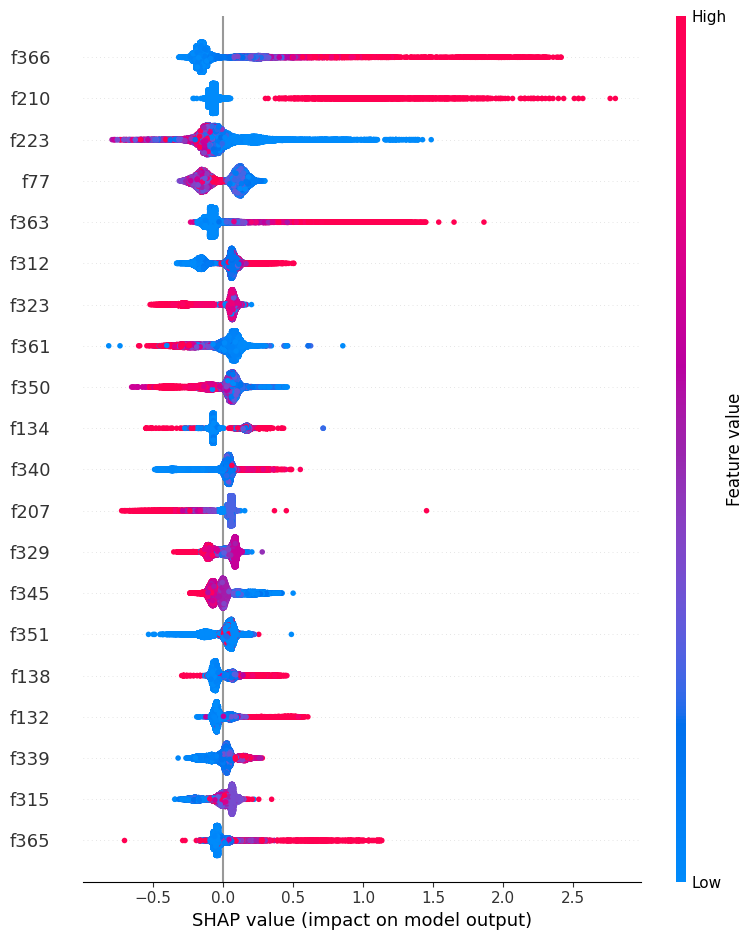

In [12]:
import shap

# Fit the explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

# Plot summary to visualize important features
shap.summary_plot(shap_values, X_train)

# Optional: Drop low-importance features manually and retrain
# You can drop columns where mean SHAP < threshold like 0.01


In [15]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Retrain on resampled data
best_model.fit(X_resampled, y_resampled)
y_probs = best_model.predict_proba(X_test)[:, 1]
smote_map = average_precision_score(y_test, y_probs)
print("MAP with SMOTE:", smote_map)


MAP with SMOTE: 0.7671078001037267


In [20]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
